# MNIST dataset
- Architecture:
    - Multilayer perceptron:
        - Input dimensions: 784
        - First hidden layer dimensions: 256
        - Second hidden layer dimensions: 64
        - Output layer dimensions: 10
        - ReLu activations in hidden layers

- Loss function:
    -Cross entropy with softmax activation.
- Testing accuracy:
    - ≈ 98% after 50 epochs

In [1]:
# Transformations
import torch.utils.data
# Datasets
import torchvision.datasets
# Visualizations
import math
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
# Model creation
import torch.nn

# Load Data
- The data is normalized into range [0, 1]

In [13]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomRotation(degrees=10),
    torchvision.transforms.ToTensor()])

# Dataset is only downloaded once
train_dataset = torchvision.datasets.MNIST(root='datasets/', train=True, download=True, transform=train_transforms)
test_dataset = torchvision.datasets.MNIST(root='datasets/', train=False, download=True, transform=torchvision.transforms.ToTensor())

In [3]:
batch_size = 25
traindataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
testdataloader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=batch_size)

# Visualize samples

In [4]:
it = iter(traindataloader)

sample_imgs, sample_labels = next(it)

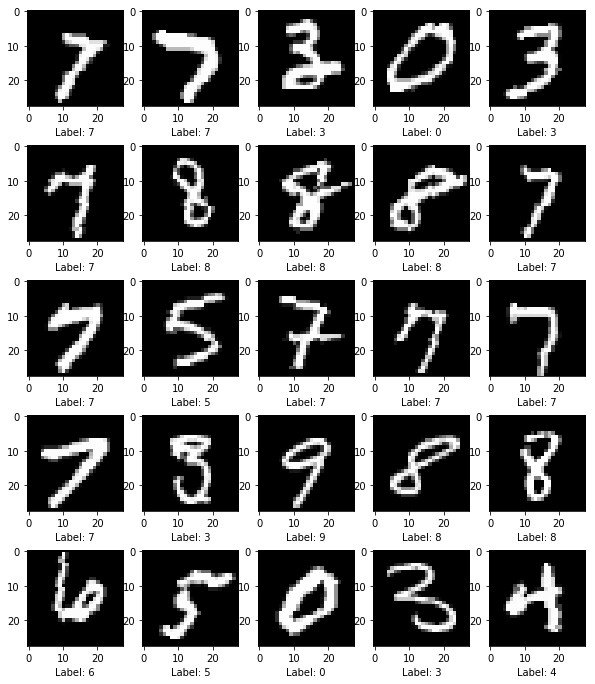

In [5]:
f_dim = math.ceil(math.sqrt(batch_size))
f, axes = plt.subplots(f_dim, f_dim, figsize=(10, 12));
axes = axes.flatten()

for ax in axes:
    ax.imshow(np.zeros([28, 28]), cmap='gray')

for ax, img, label in zip(axes, sample_imgs, sample_labels):
    ax.imshow(img.numpy().flatten().reshape(28, 28), cmap='gray');
    ax.set_xlabel('Label: {}'.format(label.item()));

# Create model

In [6]:
model = torch.nn.Sequential(torch.nn.Linear(28*28, 256),
                            torch.nn.ReLU(),
                            torch.nn.Linear(256, 64),
                            torch.nn.ReLU(),
                            torch.nn.Linear(64, 10))
# No need to add softmax HERE
# It's added by the loss function
# https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss
# torch.nn.Softmax(dim=1))

In [7]:
# The loss expects a linear output from the last layer!
criterion = torch.nn.CrossEntropyLoss()

In [8]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [9]:
# Move model to cuda
model.cuda()

n_epochs = 50
train_losses = []
test_losses = []
test_accuracies = []

for e in range(n_epochs):
    epoch_train_loss = 0
    for imgs, labels in traindataloader:
        imgs = imgs.view([-1, 28*28]).cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()

        optimizer.step()
        epoch_train_loss += loss.item() * len(imgs)
    
    epoch_test_loss = 0
    test_accuracy = 0
    for imgs, labels in testdataloader:
        model.eval()
        imgs = imgs.view([-1, 28*28]).cuda()
        labels = labels.cuda()
        
        output = model(imgs)
        loss = criterion(output, labels)
        
        epoch_test_loss += loss.item() * len(imgs)
        top_prob, top_class = output.topk(1, dim=1)
        test_accuracy += ((labels.view(top_class.shape) == top_class).sum().item())
    
    test_accuracy /= len(testdataloader.dataset)
    train_losses.append(epoch_train_loss)
    test_losses.append(epoch_test_loss)
    test_accuracies.append(test_accuracy)
    
    model.train()
    print('Average Training Loss in epoch {} is: {}'.format(e, epoch_train_loss/ len(traindataloader.dataset)))
    print('Average Testing Loss in epoch {} is: {}'.format(e, epoch_test_loss/ len(testdataloader.dataset)))
    print('Testing Accuracy in epoch {} is: {}'.format(e, test_accuracy))
    print()

Average Training Loss in epoch 0 is: 1.0150371772485476
Average Testing Loss in epoch 0 is: 0.3893047579936683
Testing Accuracy in epoch 0 is: 0.8868

Average Training Loss in epoch 1 is: 0.38198892754347374
Average Testing Loss in epoch 1 is: 0.3035852186009288
Testing Accuracy in epoch 1 is: 0.9135

Average Training Loss in epoch 2 is: 0.318058487342981
Average Testing Loss in epoch 2 is: 0.2629725160636008
Testing Accuracy in epoch 2 is: 0.924

Average Training Loss in epoch 3 is: 0.27171171991697823
Average Testing Loss in epoch 3 is: 0.2165221119346097
Testing Accuracy in epoch 3 is: 0.9363

Average Training Loss in epoch 4 is: 0.23544018555743
Average Testing Loss in epoch 4 is: 0.19058745378628372
Testing Accuracy in epoch 4 is: 0.9432

Average Training Loss in epoch 5 is: 0.20587191622704268
Average Testing Loss in epoch 5 is: 0.17168700667796657
Testing Accuracy in epoch 5 is: 0.9508

Average Training Loss in epoch 6 is: 0.18345106173151482
Average Testing Loss in epoch 6 is: 

# Visualize the loss
- Testing losses are starting to fluctuate during the last 10 epochs (Overfitting).

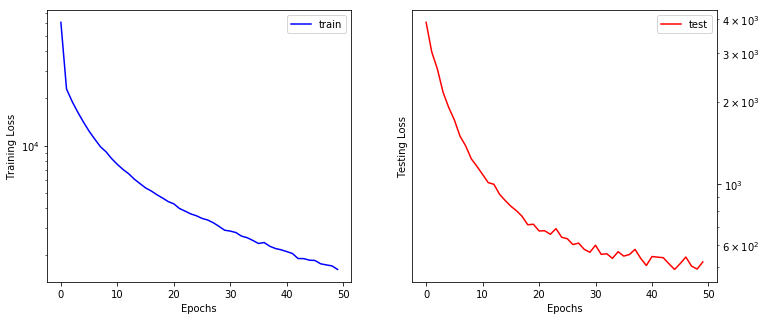

In [46]:
epochs = [e for e in range(n_epochs)]
f = plt.figure(figsize=(12, 5))
ax = f.add_subplot(1, 2, 1)
ax.plot(epochs, train_losses, 'b', label='train');
ax.legend()
ax.set_yscale('log')
ax.set_xlabel('Epochs')
ax.set_ylabel('Training Loss')

ax = f.add_subplot(1, 2, 2)
ax.plot(epochs, test_losses, 'r', label='test');
ax.legend()
ax.yaxis.tick_right();
ax.set_yscale('log')
ax.set_xlabel('Epochs')
ax.set_ylabel('Testing Loss');

# Validate the results

In [11]:
def classify_images(imgs):
    output = model(imgs.view([-1, 28*28]).cuda())
    prediction = output.argmax(dim=1)
    return prediction

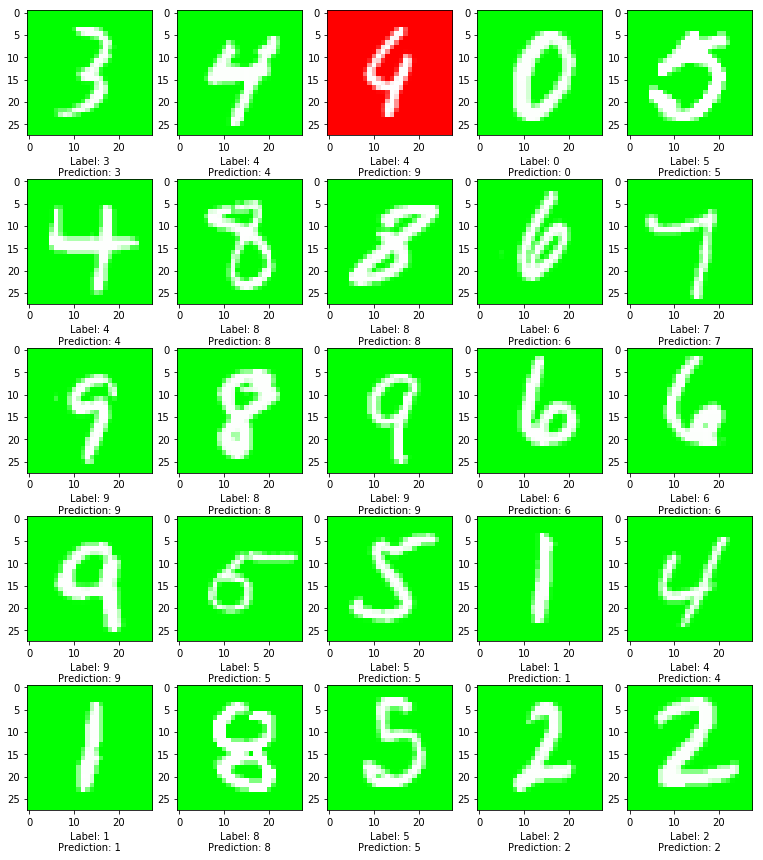

In [52]:
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt

f_dim = math.ceil(math.sqrt(batch_size))
f, axes = plt.subplots(f_dim, f_dim, figsize=(13, 15));
axes = axes.flatten()

# Initialize plots by an empty image
for ax in axes:
    ax.imshow(np.zeros([28, 28]), cmap='gray')

imgs, labels = next(iter(testdataloader))
for ax, img, label in zip(axes, imgs, labels):
    prediction = classify_images(img)
    img = img.numpy().flatten().reshape(28, 28)
    img = np.stack((img,)*3, axis=-1)
    label = label.cuda()

    if prediction == label:
        img[:, :, 1] = 1
    else:
        img[:, :, 0] = 1
    ax.imshow(img);
    ax.set_xlabel('Label: {}\nPrediction: {}'.format(label.item(), prediction.item()));